In [1]:
library(tidyverse)
library(cowplot)
library(ggrepel)
library(ROCR)
library(pROC)
library(MLmetrics)


`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘MLmetrics’

The following object is masked from ‘package:base’:

    Recall



# 1. Investigate calibration of XSwap vs (scaled) degree product

In [2]:
compute_equal_bin_calibration <- function(df, num_bins) {
    features <- c('xswap_prior', 'analytic_prior', 'scaled_degree')
    
    calibration_df <- data.frame()
    for (feature in features) {
        cal_df <- df %>%
            select(feature_value = starts_with(feature), edge) %>%
            arrange(desc(feature_value)) %>%
            mutate(
                indicator = seq(n()),
                bin_number = ntile(feature_value, num_bins),
            ) %>%
            group_by(bin_number) %>%
            summarize(
                num_edges = sum(edge),
                bin_size = n(),

                bin_mean_feature = mean(feature_value),
                bin_std_feature = sd(feature_value),
            ) %>% 
            ungroup() %>%
            mutate(
                expected_percent_correct = (num_edges + 1/2) / (bin_size + 1),
                lower_ci = qbeta(c(0.025), num_edges + 1/2, bin_size - num_edges + 1/2),
                upper_ci = qbeta(c(0.975), num_edges + 1/2, bin_size - num_edges + 1/2),
                feature = feature,
            )

        calibration_df <- bind_rows(calibration_df, cal_df)
        rm(cal_df)
    }
    calibration_df %>%
        select(feature, bin_number:upper_ci)
}

compute_calibration_metrics <- function(df) {
    features <- c('xswap_prior', 'analytic_prior', 'scaled_degree')

    metrics_df <- data.frame()
    for (feature in features) {
        met_df <- df %>%
            select(feature_value = starts_with(feature), edge) %>%
            summarize(
        #         mae = MAE(y_true = edge, y_pred = feature_value),
        #         mse = MSE(y_true = edge, y_pred = feature_value),
        #         rmse = RMSE(y_true = edge, y_pred = feature_value),
                auroc = auc(formula = edge ~ feature_value),
        #         median_ae = MedianAE(y_true = edge, y_pred = feature_value),
                # Note all_false actually has infinite mean cross entropy
                mxe = - mean(edge * log(feature_value + 1e-100) + (1-edge) * log(1-feature_value + 1e-100)),
                w_mae = weighted.mean(abs(edge - feature_value), 
                                      w = (edge / sum(edge)) + (1-edge) / sum(1-edge)),
            ) %>%
            mutate(feature = feature)
        metrics_df <- bind_rows(metrics_df, met_df)
    }
    metrics_df
}

In [3]:
equal_bin_calibration_plots_df <- data.frame()
calibration_metrics_df <- data.frame()

for (filename in list.files('calibration-priors/', full.names = T)) {
    metaedge <- str_extract(string = filename, pattern = '(?<=//).+(?=.csv.gz)')
    print(metaedge)
    prior_df <- read_csv(filename) %>%
        mutate(
            degree_product = source_degree * target_degree,
            analytic_prior = degree_product / (degree_product - source_degree - target_degree
                                               + sum(edge) + 1),
            scaled_degree = degree_product / max(degree_product),
        ) %>%
        select(-source_degree, -target_degree, -degree_product)
    
    # Compute and save overall metrics to assess calibration
    cal_metrics <- compute_calibration_metrics(prior_df) %>%
        mutate(metaedge = metaedge)
    calibration_metrics_df <- bind_rows(calibration_metrics_df, cal_metrics)
    
    # Compute and save calibration bins
    equal_bin_calibration_df <- compute_equal_bin_calibration(df = prior_df, num_bins = 25) %>%
        mutate(metaedge = metaedge)
    rm(prior_df)
    
    equal_bin_calibration_plots_df <- bind_rows(equal_bin_calibration_plots_df, equal_bin_calibration_df)
    rm(equal_bin_calibration_df)
    
    write.csv(equal_bin_calibration_plots_df, file = 'calibration_bins.csv')
    write.csv(calibration_metrics_df, file = 'calibration_metrics.csv')
}

[1] "AdG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "AeG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "AlD"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "AuG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "CbG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "CCpG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "CcSE"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "CdG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "CiPC"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "CpD"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "CrC"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "CtD"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "CuG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "DaG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "DdG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "DpS"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "DrD"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "DuG"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "GpMF"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

[1] "GpPW"


Parsed with column specification:
cols(
  source_id = col_double(),
  target_id = col_double(),
  edge = col_logical(),
  source_degree = col_double(),
  target_degree = col_double(),
  xswap_prior = col_double()
)
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message in bind_rows_(x, .id):
“Vectorizing 'auc' elements may not preserve their attributes”

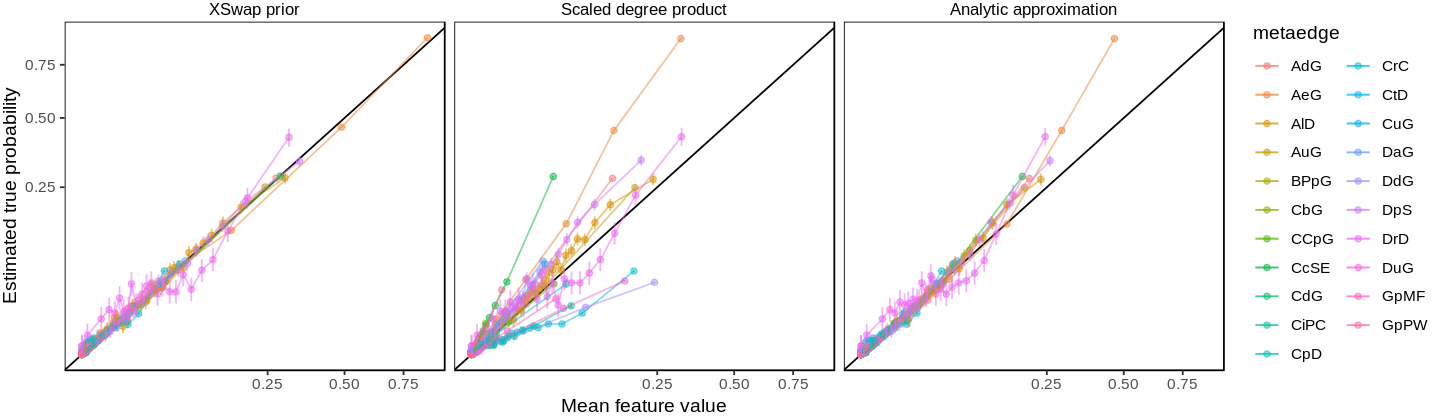

In [11]:
options(repr.plot.width=12, repr.plot.height=3.5)

equal_bin_calibration_plot_color <- equal_bin_calibration_plots_df %>% 
    mutate(feature = feature %>% recode_factor(xswap_prior = 'XSwap prior', 
                                               scaled_degree = 'Scaled degree product',
                                               analytic_prior = 'Analytic approximation')) %>%
    ggplot(aes(x = bin_mean_feature, y = expected_percent_correct, 
               ymin = lower_ci, ymax = upper_ci, color = metaedge)) +
    geom_abline() +
    geom_point(alpha = 0.5) +
    geom_line(alpha = 0.5) +
    geom_errorbar(alpha = 0.5) +
    facet_wrap(vars(feature)) +
    scale_x_continuous(trans = 'sqrt') +
    scale_y_continuous(trans = 'sqrt') +
    xlab('Mean feature value') +
    ylab('Estimated true probability') +
    theme_zietzm()

ggsave(filename = 'equal_bin_calibration_color.png', plot = equal_bin_calibration_plot_color,
       width = 12, height = 3.5, dpi = 300)

equal_bin_calibration_plot_color

## AUROC vs Calibration

#### Question:
Does AUROC for a given metaedge have anything to do with its calibration?

#### Answer:
It does not appear so. `CtD` has medium calibration (w-RMSE), on average, while having the highest AUROC. `CcSE` has the best calibration but medium performance, while `AlD` has poor performance along both lines of analysis. Meanwhile, while XSwap, the analytic prior approximation, and the scaled degree product have various levels of calibration, all exhibit almost exactly the same AUROC for the same task.

In [ ]:
options(repr.plot.width=7, repr.plot.height=6)

full_auroc_df <- full_auroc_df %>% 
    mutate(feature = feature %>% recode_factor(xswap_prior = 'XSwap prior', 
                                               scaled_degree = 'Scaled degree product',
                                               scaled_xswap = 'Scaled XSwap prior'))


by_metaedge <- (
    ggplot(full_auroc_df, aes(group = feature, x = metaedge, y = auroc, label = feature))
    + geom_point()
    + geom_line()
    + geom_label_repel(data = full_auroc_df %>% filter(metaedge == 'CtD'), 
                       nudge_x = 1, nudge_y = -0.15, segment.alpha = 0.2)
    + coord_cartesian(ylim = c(0.5, 1))
    + ylab("Self-reconstruction AUROC")
)

by_feature <- (
    ggplot(full_auroc_df, aes(group = metaedge, x = feature, y = auroc, label = metaedge))
    + geom_point()
    + geom_line()
    + geom_label_repel(data = full_auroc_df %>% filter(feature == 'Scaled XSwap prior'), 
                       nudge_x = 1, nudge_y = -0.15, segment.alpha = 0.2)
    + coord_cartesian(ylim = c(0.5, 1))
    + ylab("Self-reconstruction AUROC")
)

plot_grid(by_metaedge, by_feature, ncol = 1)

# 2. Investigate differentially-ranked node (pairs)

In [ ]:
xswap_degree_rank <- read_csv('calibration-priors/CcSE.csv.gz') %>%
        mutate(
            degree_product = source_degree * target_degree,
            scaled_degree = degree_product / max(degree_product),
            scaled_xswap = xswap_prior / max(xswap_prior),
            xswap_rank = percent_rank(desc(xswap_prior)),
            degree_rank = percent_rank(desc(degree_product)),
            rank_diff = xswap_rank - degree_rank,
            scaled_diff = scaled_xswap - scaled_degree,
        )

xswap_degree_rank %>% head

## Within degree-product node pair variation

#### Question: 
Does the source/target degree combination matter given the same product? For example, would you expect node pairs with degree 3 and 4 to have the same XSwap prior as ones with 6 and 2, since both have degree product of 12?

#### Answer:
The XSwap priors do not appear to be the same, but they appear to be randomly distributed with respect to source degree.

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)

(
    ggplot(xswap_degree_rank %>%
            group_by(degree_product) %>%
            mutate(
                n = n(),
                distinct = n_distinct(source_degree),
            ) %>%
            ungroup() %>%
            filter(degree_product %in% c(12, 8, 16, 18, 24, 28)) %>%
            group_by(degree_product, source_degree) %>%
            summarize(
                n_source = n(),
                xswap = first(xswap_prior),
            ),
           aes(x = source_degree, y = xswap, size = n_source))
    + geom_point()
    + facet_wrap(vars(degree_product), scales = 'free')
    + theme_zietzm()
)

## Difference in rank vs features

#### Question


#### Answer

In [ ]:
options(repr.plot.width=6, repr.plot.height=12)

rank_diff <- (
    ggplot(xswap_degree_rank %>% 
               sample_n(10000) %>% 
               gather('feature', 'value', xswap_prior, degree_product, scaled_degree, 
                      scaled_xswap, xswap_rank, degree_rank), 
           aes(x = value, y = rank_diff))
    + geom_point(alpha = 0.5)
    + facet_wrap(vars(feature), scale = 'free', ncol = 2)
    + theme_zietzm()
)

scaled_diff <- (
    ggplot(xswap_degree_rank %>% 
               sample_n(10000) %>% 
               gather('feature', 'value', xswap_prior, degree_product), 
           aes(x = value, y = scaled_diff))
    + geom_point(alpha = 0.5)
    + facet_wrap(vars(feature), scale = 'free')
    + theme_zietzm()
)

unscaled_diff <- (
    ggplot(xswap_degree_rank %>% 
               sample_n(20000) %>% 
               mutate(abs_diff = xswap_prior - scaled_degree) %>%
               gather('feature', 'value', xswap_prior, scaled_degree), 
           aes(x = value, y = abs_diff))
    + geom_point(alpha = 0.5)
    + facet_wrap(vars(feature), scale = 'free')
    + theme_zietzm()
)


plot_grid(rank_diff, scaled_diff, unscaled_diff, ncol = 1, rel_heights = c(2.9, 1, 1))

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)

full <- (
    ggplot(xswap_degree_rank %>% sample_n(50000) %>% arrange(abs(rank_diff)), 
           aes(x = xswap_rank, y = degree_rank, color = abs(rank_diff)))
    + geom_point(alpha = 0.5)
    + geom_abline()
)

full

In [ ]:
xswap_degree_rank %>%
    mutate(degree_diff = source_degree - target_degree) %>% 
    filter(degree_product > 0 & abs(degree_diff) < 500)

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)

(
    ggplot(xswap_degree_rank %>%
               mutate(degree_diff = source_degree - target_degree) %>% 
               filter(degree_product > 0) %>%
               sample_n(500000) %>%
               arrange(rank_diff),
           aes(x = degree_diff, y = rank_diff))
    + geom_point(alpha = 0.3)
    + geom_hline(yintercept = 0, color = 'grey', linetype = 'dashed')
    + geom_vline(xintercept = 0, color = 'grey', linetype = 'dashed')
    + xlab('Source degree - target degree')
    + ylab('XSwap percentile - degree product percentile')
    + theme_zietzm()
)

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)

(
    ggplot(xswap_degree_rank %>%
               mutate(degree_diff = source_degree - target_degree) %>% 
               filter(degree_product > 0) %>%
               sample_n(500000) %>%
               arrange(rank_diff),
           aes(x = degree_diff, y = rank_diff))
    + stat_density_2d(aes(fill = stat(level)), geom = "polygon")
    + geom_hline(yintercept = 0, color = 'grey', linetype = 'dashed')
    + geom_vline(xintercept = 0, color = 'grey', linetype = 'dashed')
    + xlab('Source degree - target degree')
    + ylab('XSwap percentile - degree product percentile')
    + theme_zietzm()
)

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)

(
    ggplot(xswap_degree_rank %>%
               sample_n(100000),
           aes(x = abs(source_degree - target_degree), y = rank_diff))
    + geom_point(alpha = 0.5)
    + geom_hline(yintercept = 0, color = 'grey', linetype = 'dashed')
    + geom_vline(xintercept = 0, color = 'grey', linetype = 'dashed')
#     + xlab('absSource degree - target degree')
    + ylab('XSwap percentile - degree product percentile')
    + theme_zietzm()
)

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)

full <- (
    ggplot(xswap_degree_rank %>% sample_n(50000) %>% arrange(abs(rank_diff)), 
           aes(x = xswap_prior, y = scaled_degree, color = abs(rank_diff)))
    + geom_point(alpha = 0.5)
    + geom_abline()
)

full

In [ ]:
xswap_degree_rank %>%
    top_n(10, wt = abs(rank_diff))

In [ ]:
xswap_degree_rank %>% 
    top_n(10, wt = xswap_rank)